In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch

# to get deterministic output
torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [2]:
df = pd.read_csv("../datasets/perceptron_toydata-truncated.txt", sep="\t")
df

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0
5,0.39,-1.99,0
6,-0.49,-2.74,0
7,-0.68,-1.52,0
8,-0.10,-3.43,0
9,-0.05,-1.95,0


In [3]:
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

print("Train set:", X_train.shape, y_train.shape)

Train set: (20, 2) (20,)


In [4]:
print("Training labels:")
counts = Counter(y_train)
for key, value in counts.items():
    print(f"{key}: {value}")

Training labels:
0: 10
1: 10


### Vizualize the Dataset

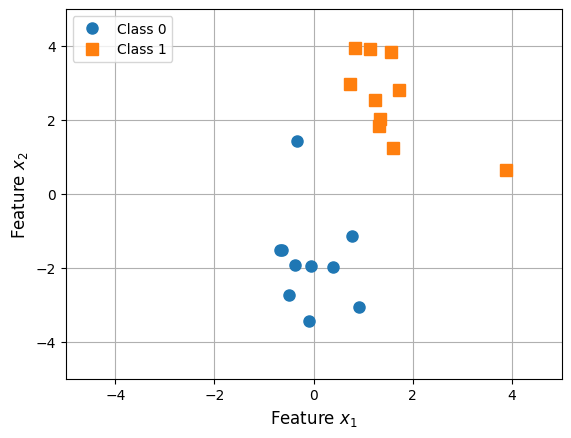

In [5]:
from modules.plotting_helper import plot_feature2d
plot_feature2d(X_train, y_train, markersize=8)

### Design the Model
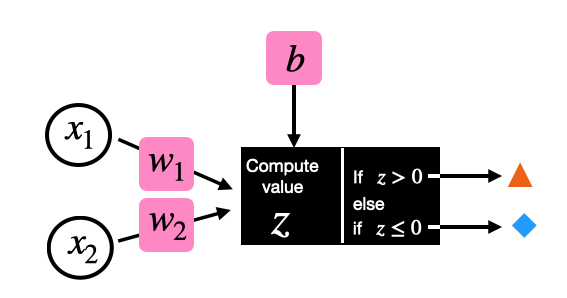

In [6]:
class Perceptron():
    def __init__(self, input_dim):     
        self.weights = torch.zeros(input_dim, requires_grad=True)
        self.bias = torch.zeros(1, requires_grad=True)
    
    def forward(self, x):
        z = torch.matmul(x, self.weights) + self.bias
        return torch.sigmoid(z)
    
    def __call__(self, x):
        return self.forward(x)
    
    def predict(self, x):
        with torch.inference_mode(): # disable grads
            return self(x)
    
    @classmethod
    def accuracy(cls, y_true, y_pred):
        return torch.sum(y_pred == y_true) / len(y_true)

def binary_cross_entropy_loss(y_pred, y_true):
    eps = 1e-7
    y_pred = torch.clamp(y_pred, eps, 1 - eps) # to avoid log(0)
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
model = Perceptron(input_dim=2)

### Train the Model

In [7]:
def train(model, num_epochs, lr):
    history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in zip(X_train_tensor, y_train_tensor):
            # forward pass
            y_pred = model(x_batch)
            loss = binary_cross_entropy_loss(y_pred, y_batch)
            
            # clear the previous grads
            if model.bias.grad:
                model.weights.grad.zero_()
                model.bias.grad.zero_()
            
            # backward pass            
            loss.backward() # compute grads
            with torch.no_grad():                
                model.weights -= lr * model.weights.grad
                model.bias -= lr * model.bias.grad
                 
            epoch_loss += abs(loss.item())
        history.append((loss.item(), model.bias.item(), model.weights.tolist()))
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | epoch_loss: {epoch_loss:.2f}')
    return history

history = train(model, num_epochs=10, lr=0.5)

Epoch: 001/010 | epoch_loss: 4.17
Epoch: 002/010 | epoch_loss: 2.08
Epoch: 003/010 | epoch_loss: 1.56
Epoch: 004/010 | epoch_loss: 1.23
Epoch: 005/010 | epoch_loss: 1.02
Epoch: 006/010 | epoch_loss: 0.87
Epoch: 007/010 | epoch_loss: 0.76
Epoch: 008/010 | epoch_loss: 0.67
Epoch: 009/010 | epoch_loss: 0.60
Epoch: 010/010 | epoch_loss: 0.54


In [8]:
bias = model.bias.item()
weights = model.weights.tolist()
print("Bias:", bias)
print("Weights:", weights)

Bias: -2.6817495822906494
Weights: [2.5812840461730957, 1.6353051662445068]


### Evaluate the model

In [9]:
predictions = model.predict(X_train_tensor)
y_preds = (predictions >= 0.5).float()

train_acc = model.accuracy(y_train_tensor, y_preds)
print(f"Train Accuracy: {train_acc:.2f}")

Train Accuracy: 1.00


### Visualize the Results

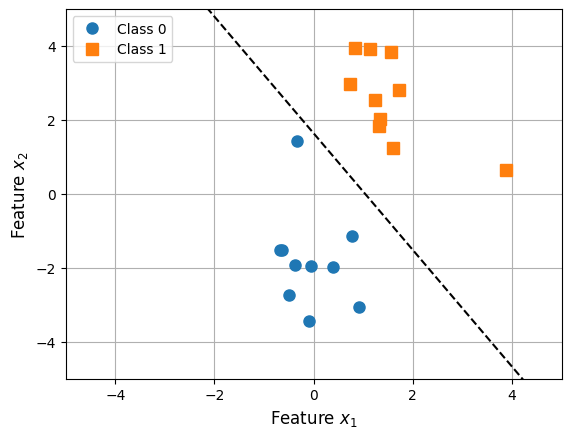

In [10]:
plot_feature2d(X_train, y_train, bias, weights, markersize=8)

### Vizualize Training Epochs

epoch_idx: 0, loss: 0.0173, bias: -0.5958, weights: ['1.3370', '1.4410']


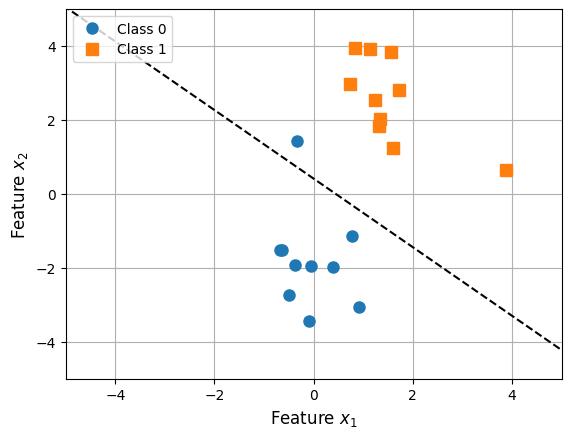

epoch_idx: 1, loss: 0.0236, bias: -1.0966, weights: ['1.4968', '1.4387']


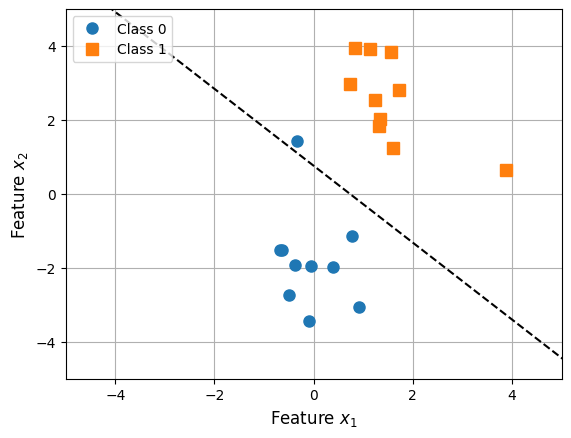

epoch_idx: 2, loss: 0.0263, bias: -1.4580, weights: ['1.6756', '1.4508']


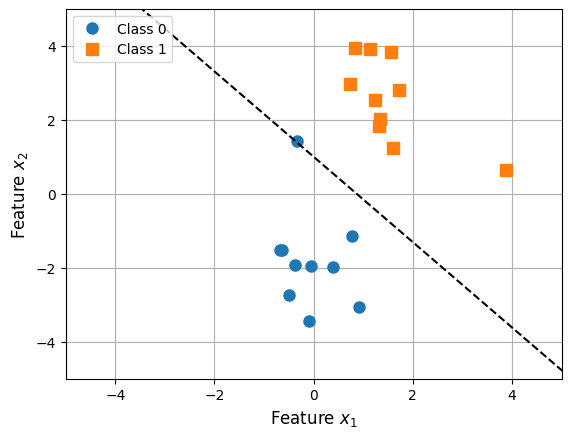

epoch_idx: 3, loss: 0.0262, bias: -1.7335, weights: ['1.8462', '1.4756']


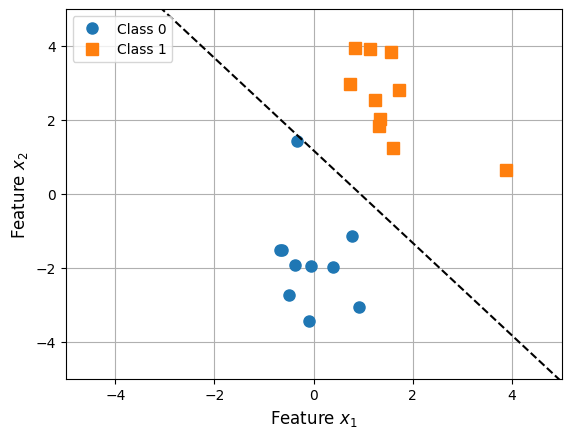

epoch_idx: 4, loss: 0.0250, bias: -1.9552, weights: ['2.0017', '1.5039']


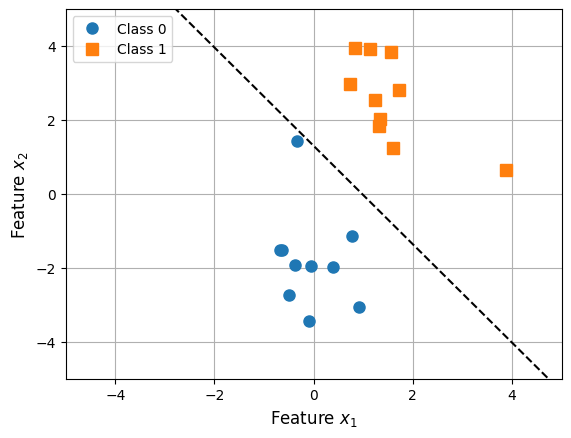

epoch_idx: 5, loss: 0.0235, bias: -2.1410, weights: ['2.1418', '1.5322']


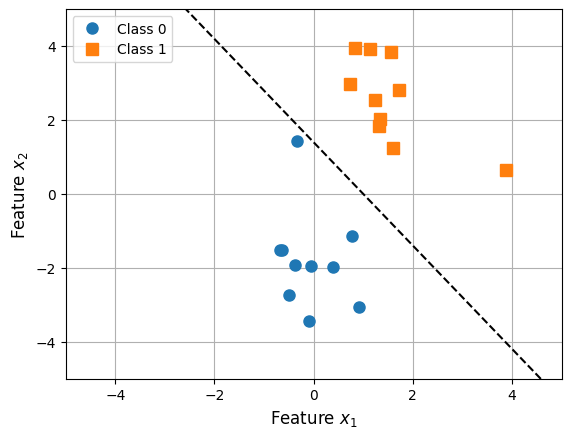

epoch_idx: 6, loss: 0.0220, bias: -2.3011, weights: ['2.2679', '1.5597']


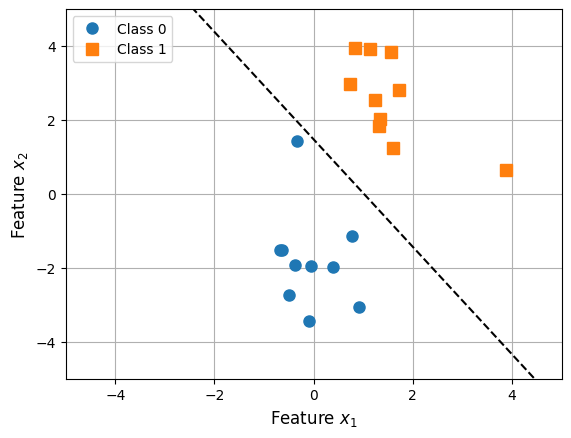

epoch_idx: 7, loss: 0.0205, bias: -2.4420, weights: ['2.3821', '1.5860']


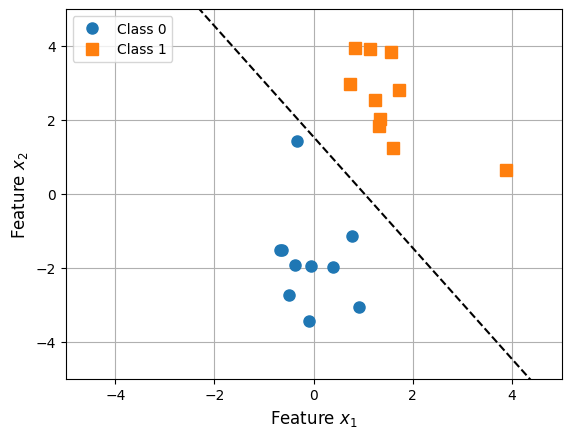

epoch_idx: 8, loss: 0.0192, bias: -2.5679, weights: ['2.4861', '1.6112']


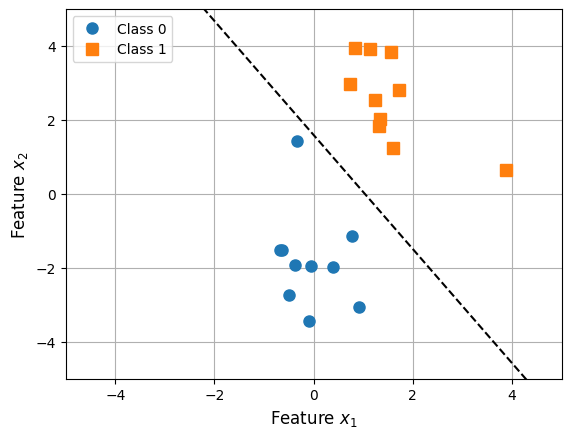

epoch_idx: 9, loss: 0.0180, bias: -2.6817, weights: ['2.5813', '1.6353']


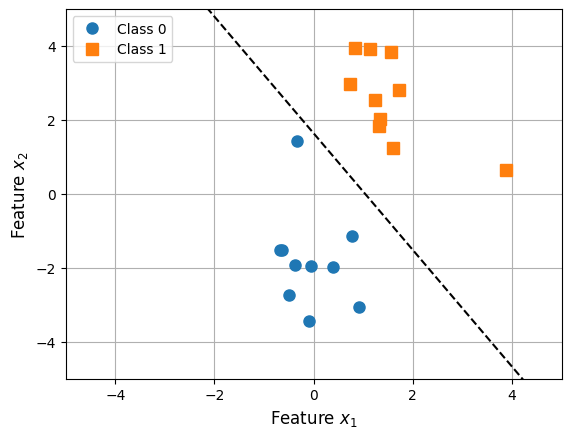

In [11]:
for idx, metrices in enumerate(history):
    if metrices[0] != 0: # loss
        formatted_w = [f"{x:.4f}" for x in metrices[2]]
        print(f"epoch_idx: {idx}, loss: {metrices[0]:.4f}, bias: {metrices[1]:.4f}, weights: {formatted_w}")
        plot_feature2d(X_train, y_train, metrices[1], metrices[2], markersize=8)